<a href="https://colab.research.google.com/github/marko20014/skills-introduction-to-github/blob/main/ResNet18_STL10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Transfer Learning <br>
Training a model from scratch can be time consuming and computationaly heavy.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models
import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
#the size of our mini batches
batch_size     = 64
#How many iterations of our dataset
num_epochs     = 10
#optimizer learning rate
learning_rate  = 1e-4
#initialise what epoch we start from
start_epoch    = 0
#initialise best valid accuracy
best_valid_acc = 0
#where to load/save the dataset from
data_set_root  = "data"
#what to resize our images to
image_size     = 64

In [ ]:
save_checkpoint = False
start_from_checkpoint = False
save_dir = 'Models'
model_name = 'Res_18_STL10'

In [ ]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

# Some preprocess to the dataset. eg: Convert the images to tensor

# Data Augmentation Transform<br>



In [ ]:
# Prepare a composition of transforms
transform = transforms.Compose([
            transforms.RandomCrop(image_size),      #Random crop
            transforms.RandomHorizontalFlip(p=0.5), #random horizontal flip with 50% chance
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

# Create the training, testing and validation data

In [ ]:
#Define our STL10 Datasets
train_data = datasets.STL10(data_set_root, split='train', download=True, transform=transform)
test_data = datasets.STL10(data_set_root, split='test', download=True, transform=transform)

#Split trainging data into train and validation set with 90/10% traning/validation split
validation_split = 0.9

n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

100%|██████████| 2640397119/2640397119 [03:59<00:00, 11026050.20it/s]


Extracting data/stl10_binary.tar.gz to data
Files already downloaded and verified


# Check the lengths of all the datasets

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4500
Number of validation examples: 500
Number of testing examples: 8000


# Create the dataloader

In [ ]:
#Create the training, Validation and Evaluation/Test Datasets
train_loader = dataloader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader(valid_data, batch_size=batch_size)
test_loader  = dataloader(test_data, batch_size=batch_size)

In [ ]:
#This Function will allow us to scale an images pixel values to a value between 0 and 1
def normalize_img(img):
    mins = img.min(0, keepdims = True).min(1, keepdims = True)
    maxs = img.max(0, keepdims = True).max(1, keepdims = True)
    return (img - mins)/(maxs - mins)

# Visualise the data <br>
It is always important to fully understand what you are training your network with

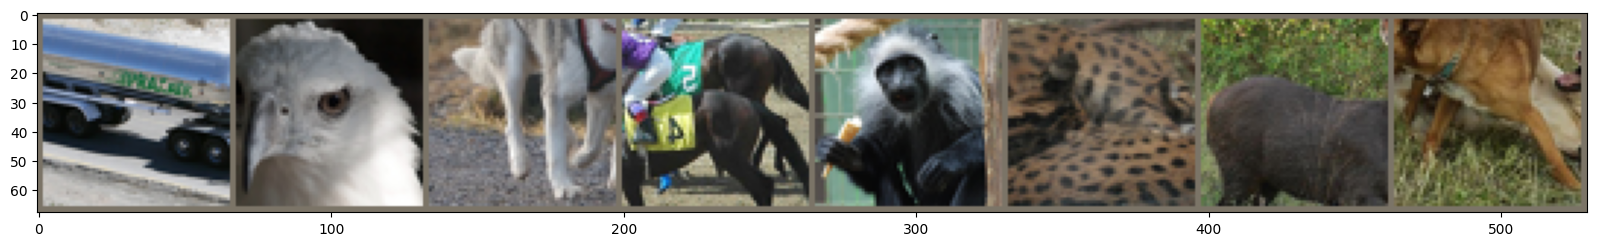

In [ ]:
plt.figure(figsize = (20,10))
images, labels = next(iter(train_loader))
out = torchvision.utils.make_grid(images[0:8])
plt.imshow(normalize_img(out.numpy().transpose((1, 2, 0))))

# Create the pretrained network <br>
First train the ResNet from scratch and collect the results for the training and evaluation accuracy and training time<br>


<b> Weight "Freezing"</b>
<br>
By "freezing" parts of the network like this we can speed up the training of the model as we will only be updating a single layer, this is especially useful if our pretrained model is very big

In [ ]:
#Create a ResNet18 from the pytorch "models" module
Res_net = models.resnet18(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


Lets see the structure of this network

In [ ]:
#view the network
Res_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The ImageNet challange dataset that the ResNet model was trained on has 1000 classes but the STL10 dataset only has 10 <br>
We can still use the pretrained model we just need to alter it a bit by simply replacing the last FC (linear) layer with a new one

In [ ]:
#Augment the model, by swapping out the last fc layer for a different one
#get the number of in_features into the last fc layer
num_ftrs = Res_net.fc.in_features
#redefine the last fc layer with a linear layer with 10 ouputs, this layer's weights will be randomly initialised
Res_net.fc = nn.Linear(num_ftrs, 10).to(device)

In [ ]:
#pass image through network
out = Res_net(images.to(device))
#check output
out.shape

torch.Size([64, 10])

# Set up the optimizer

In [ ]:
#Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(Res_net.parameters(), lr = learning_rate)

In [ ]:
#Define a Cross Entropy Loss
Loss_fun = nn.CrossEntropyLoss()

# Loading Checkpoints

In [ ]:
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
save_path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if start_from_checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(save_path):
        #load Checkpoint
        check_point = torch.load(save_path)
        #Checkpoint is saved as a python dictionary
        #https://www.w3schools.com/python/python_dictionaries.asp
        #here we unpack the dictionary to get our previous training states
        Res_net.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
        best_valid_acc = check_point['valid_acc']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(save_path):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Starting from scratch


# Define the accuracy calculator

In [ ]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

# Define the training process

In [ ]:
#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, loss_fun, loss_logger):

    #initialise counters
    epoch_loss = 0
    epoch_acc = 0

    #Set Network in train mode
    net.train()

    for i, (x, y) in enumerate(loader):

        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.to(device) # y is the corresponding label

        #Forward pass of image through network and get output
        fx = net(x)

        #Calculate loss using loss function
        loss = loss_fun(fx, y)

        #calculate the accuracy
        acc = calculate_accuracy(fx, y)

        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()

        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #log the loss for plotting
        loss_logger.append(loss.item())

        #clear_output is a handy function from the IPython.display module
        #it simply clears the output of the running cell

        clear_output(True)
        print("TRAINING: | Itteration [%d/%d] | Loss %.2f |" %(i+1 ,len(loader) , loss.item()))

    #return the avaerage loss and acc from the epoch as well as the logger array
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

# Define the testing process

In [ ]:
#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#it WILL NOT be used to train out model
def evaluate(net, device, loader, loss_fun, loss_logger = None):

    epoch_loss = 0
    epoch_acc = 0

    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):

            #load images and labels to device
            x = x.to(device)
            y = y.to(device)

            #Forward pass of image through network
            fx = net(x)

            #Calculate loss using loss function
            loss = loss_fun(fx, y)

            #calculate the accuracy
            acc = calculate_accuracy(fx, y)

            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()

            #log the loss for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())

            clear_output(True)
            print("EVALUATION: | Itteration [%d/%d] | Loss %.2f | Accuracy %.2f%% |" %(i+1 ,len(loader), loss.item(), 100*(epoch_acc/ len(loader))))

    #return the avaerage loss and acc from the epoch as well as the logger array
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

<h3> Learning rate schedular </h3>
It can be useful to start with a high learning rate and then decrease it after some time allowing the optimiser to "fine tune" the model<br>
There are many different ideas about how to change the learning rate over epochs, here we will create a simple "linear decay" schedular manually.<br>
Pytorch also has automatic Learning rate scheduling

[Learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [ ]:
#Create a function that will linearly decay the learning rate every epoch
def lr_linear_decay(epoch_max, epoch, lr):
    lr_adj = ((epoch_max - epoch)/epoch_max)*lr
    #update the learning rate parameter of the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_adj

# The training process <br>
You should record the training and evaluation accuracy as well as the training time after every experiment!

In [ ]:
#Log the training and validation losses
training_loss_logger = []
validation_loss_logger = []

In [ ]:
#This cell implements our training loop

#Record the start time
Start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    #Implement the linear decay of the learning rate
    lr_linear_decay(num_epochs, epoch, learning_rate)

    #call the training function and pass training dataloader etc
    train_loss, train_acc, training_loss_logger = train(Res_net, device, train_loader, optimizer, Loss_fun, training_loss_logger)

    #call the evaluate function and pass validation dataloader etc
    valid_loss, valid_acc, validation_loss_logger = evaluate(Res_net, device, valid_loader, Loss_fun, validation_loss_logger)

    #If this model has the highest performace on the validation set
    #then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > best_valid_acc) and save_checkpoint:
        print("Saving Model")
        torch.save({
            'epoch':                 epoch,
            'model_state_dict':      Res_net.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(),
            'train_acc':             train_acc,
            'valid_acc':             valid_acc,
        }, save_path)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

End_time = time.time()

EVALUATION: | Itteration [8/8] | Loss 0.38 | Accuracy 86.79% |
| Epoch: 10 | Train Loss: 0.235 | Train Acc: 92.59% | Val. Loss: 0.394 | Val. Acc: 86.79% |


In [ ]:
print("Training time %.2f seconds" %(End_time - Start_time))

Training time 60.10 seconds


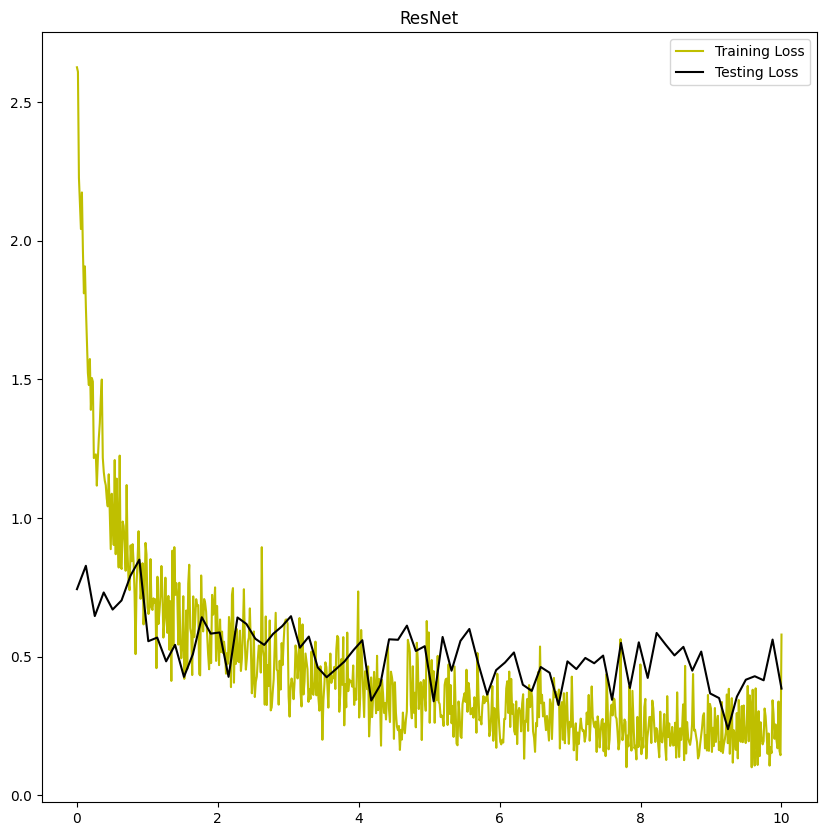

In [ ]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "k")

plt.title("ResNet")
plt.legend(["Training Loss", "Testing Loss"])

# Evaluate

In [ ]:
#call the evaluate function and pass the evaluation/test dataloader etc
test_loss, test_acc, _ = evaluate(Res_net, device, test_loader, Loss_fun)

EVALUATION: | Itteration [125/125] | Loss 0.36 | Accuracy 83.39% |
